#IMPORT FUNCTION

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer


pd.set_option('display.max_colwidth', 255)
df =pd.read_csv('drive/MyDrive/mtsamples.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')
df.head(200)

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tried Claritin, and Zyrtec. Both worked for short time b...","allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic,"
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. He exercises three times a week at home and does cardio. He has difficulty walking two b...","bariatrics, laparoscopic gastric bypass, weight loss programs, gastric bypass, atkin's diet, weight watcher's, body weight, laparoscopic gastric, weight loss, pounds, months, weight, laparoscopic, band, loss, diets, overweight, lost"
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC today. He is a very pleasant gentleman who is 42 years old, 344 pounds. He is 5'9"". He has a BMI of 51. He has been overweight for ten years since the age of 33, at his highest he was 358 pounds, at hi...","bariatrics, laparoscopic gastric bypass, heart attacks, body weight, pulmonary embolism, potential complications, sleep study, weight loss, gastric bypass, anastomosis, loss, sleep, laparoscopic, gastric, bypass, heart, pounds, weight,"
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement with left atrial diameter of 4.7 cm.,2. Normal size right and left ventricle.,3. Normal LV systolic function with left ventricular ejection fraction of 51%.,4. Normal LV diastolic function.,5. No pericard...","cardiovascular / pulmonary, 2-d m-mode, doppler, aortic valve, atrial enlargement, diastolic function, ejection fraction, mitral, mitral valve, pericardial effusion, pulmonary valve, regurgitation, systolic function, tricuspid, tricuspid valve, normal..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall thickness appear normal. The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%. There is near-cavity obliteration seen. There also ap...,"cardiovascular / pulmonary, 2-d, doppler, echocardiogram, annular, aortic root, aortic valve, atrial, atrium, calcification, cavity, ejection fraction, mitral, obliteration, outflow, regurgitation, relaxation pattern, stenosis, systolic function, tric..."
...,...,...,...,...,...
195,"Chronic venous hypertension with painful varicosities, lower extremities, bilaterally. Greater saphenous vein stripping and stab phlebectomies requiring 10 to 20 incisions, bilaterally.",Surgery,Vein Stripping,"PREOPERATIVE DIAGNOSIS: , Chronic venous hypertension with painful varicosities, lower extremities, bilaterally.,POSTOPERATIVE DIAGNOSIS: , Chronic venous hypertension with painful varicosities, lower extremities, bilaterally.,PROCEDURES,1. Greater s...","surgery, chronic venous hypertension, varicosities, stab phlebectomies, greater saphenous vein stripping, lower extremities, vein stripping, saphenous vein, vein, incisions, hemostasis, stripping, branches, phlebectomies, thigh, calf, saphenous,"
196,Fertile male with completed family. Elective male sterilization via bilateral vasectomy.,Surgery,Vasectomy - 4,"PROCEDURE: , Elective male sterilization via bilateral vasectomy.,PREOPERATIVE DIAGNOSIS: ,Fertile male with completed family.,POSTOPERATIVE DIAGNOSIS:, Fertile male with completed family.,MEDICATIONS: ,Anesthesia is local with conscious sedation.,...

In [ ]:
# menghitung jumlah kata dan memberikan peringkat mulai dari nol dari masing-masing medical specialty

medical_specialty_list = [] ; word_count_list =[]
for medical_specialty in df['medical_specialty'].unique():
    df_filter = df.loc[(df['medical_specialty'] == medical_specialty)]
    word_count_temp = df_filter['transcription'].str.split().str.len().sum()
    medical_specialty_list.append(medical_specialty)
    word_count_list.append(word_count_temp)
word_count_df = pd.DataFrame({'Medical Specialty':medical_specialty_list, 'Word Count':word_count_list})
word_count_df['Word Count'] = word_count_df['Word Count'].astype('int')
word_count_df = word_count_df.sort_values('Word Count', ascending=False)
word_count_df.reset_index(drop=True)

,Medical Specialty,Word Count
0,Surgery,526754
1,Consult - History and Phy.,287961
2,Orthopedic,198489
3,Cardiovascular / Pulmonary,160867
4,General Medicine,120978
5,Neurology,110677
6,Gastroenterology,80347
7,Radiology,74969
8,Obstetrics / Gynecology,72589
9,Urology,63419


Jumlah kata dari semua transkrips adalah: 2311419


<BarContainer object of 40 artists>

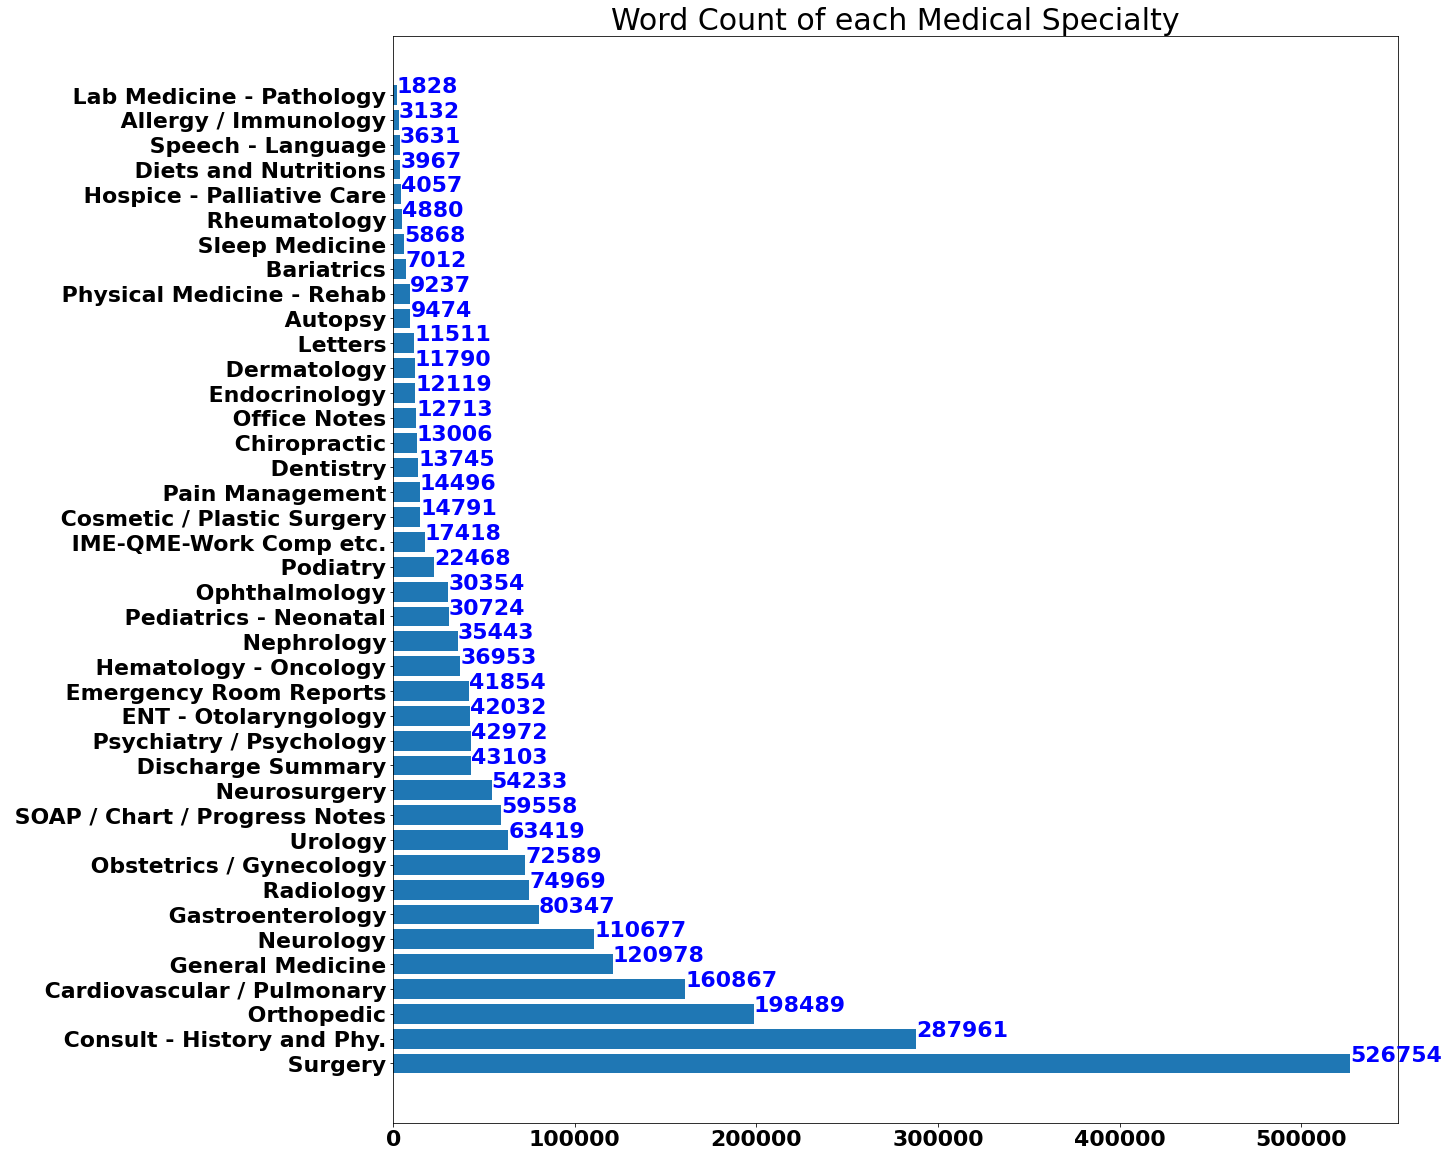

In [ ]:
#Minghitung jumlah masing-masing kata

font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)
def bar_plot(labels, value_counts, title):
    
    f, ax = plt.subplots(figsize=(18,20))
    ax.set_title(F'{title}' , fontsize=30)
    for i, v in enumerate(value_counts):
        v = round(v,1)
        ax.text(v + 0.1, i + 0.1, str(v), color='blue')
    return plt.barh(labels, value_counts)

total_word_count = df['transcription'].str.split().str.len().sum()
print(f'Jumlah kata dari semua transkrips adalah: {int(total_word_count)}')

bar_plot(word_count_df['Medical Specialty'].values, word_count_df['Word Count'].values,"Word Count of each Medical Specialty")

Ada 40 target labels


<BarContainer object of 40 artists>

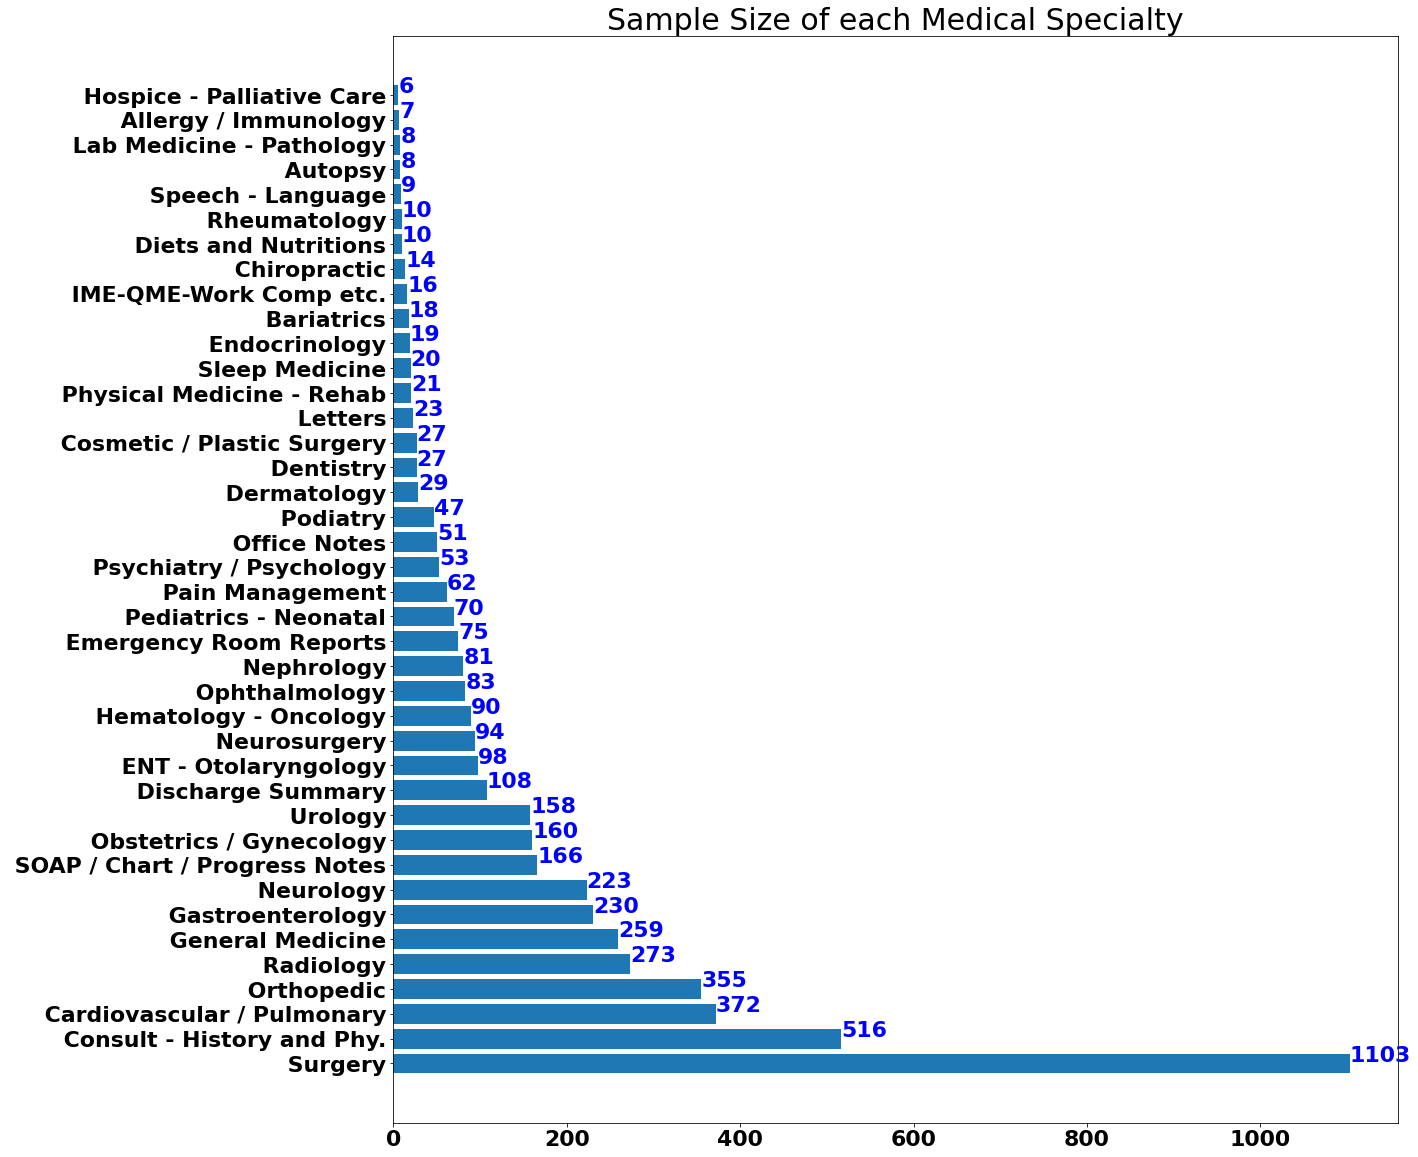

In [ ]:
# fungsi untuk meratakan satu daftar
def flat_list(unflat_list):
    flatted = [item for sublist in unflat_list for item in sublist]
    return flatted

# untuk mengkonversi jumlah nilai ke dalam format daftar
value_counts =df[['medical_specialty']].value_counts().rename_axis('medical_specialty').reset_index(name='value_counts')
labels = flat_list(value_counts[['medical_specialty']].values.tolist())
value_counts = flat_list(value_counts[['value_counts']].values.tolist())

# Untuk menghitung berapa banyak label dalam dataset`
print(f"Ada {len(labels)} target labels")

bar_plot(labels,value_counts,"Sample Size of each Medical Specialty")

In [ ]:
# GENERAL CLEANING

# untuk mencetak bentuk data
print(f'Jumlah data adalah: {df.shape}')

# untuk mengidentifikasi nilai null dengan urutan menurun
df.isnull().sum().sort_values(ascending = False)

Jumlah data adalah: (4999, 5)


keywords             1068
transcription          33
description             0
medical_specialty       0
sample_name             0
dtype: int64

In [ ]:
# untuk menghapus baris transkrips yang kosong
df = df[df['transcription'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4966 entries, 0 to 4998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4966 non-null   object
 1   medical_specialty  4966 non-null   object
 2   sample_name        4966 non-null   object
 3   transcription      4966 non-null   object
 4   keywords           3898 non-null   object
dtypes: object(5)
memory usage: 232.8+ KB


In [ ]:
# Dropping kolom redundan
df =df.drop(['description','sample_name','keywords'], axis=1)
df.head(200)

,medical_specialty,transcription
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tried Claritin, and Zyrtec. Both worked for short time b..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. He exercises three times a week at home and does cardio. He has difficulty walking two b..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC today. He is a very pleasant gentleman who is 42 years old, 344 pounds. He is 5'9"". He has a BMI of 51. He has been overweight for ten years since the age of 33, at his highest he was 358 pounds, at hi..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement with left atrial diameter of 4.7 cm.,2. Normal size right and left ventricle.,3. Normal LV systolic function with left ventricular ejection fraction of 51%.,4. Normal LV diastolic function.,5. No pericard..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall thickness appear normal. The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%. There is near-cavity obliteration seen. There also ap...
...,...,...
197,Surgery,"PREOPERATIVE DIAGNOSIS:, Desire for sterility.,POSTOPERATIVE DIAGNOSIS:, Desire for sterility.,OPERATIVE PROCEDURES: , Vasectomy.,DESCRIPTION OF PROCEDURE: , The patient was brought to the suite, where after oral sedation, the scrotum was prepped an..."
198,Surgery,"PREOPERATIVE DIAGNOSIS: , Aqueductal stenosis.,POSTOPERATIVE DIAGNOSIS:, Aqueductal stenosis.,TITLE OF PROCEDURE: ,Endoscopic third ventriculostomy.,ANESTHESIA: , General endotracheal tube anesthesia.,DEVICES:, Bactiseal ventricular catheter with a..."
199,Surgery,"PREOPERATIVE DIAGNOSES:, Increased intracranial pressure and cerebral edema due to severe brain injury.,POSTOPERATIVE DIAGNOSES: , Increased intracranial pressure and cerebral edema due to severe brain injury.,PROCEDURE:, Burr hole and insertion of ..."
200,Surgery,"PREOPERATIVE DIAGNOSIS:, Vitreous hemorrhage, right eye.,POSTOPERATIVE DIAGNOSIS: , Vitreous hemorrhage, right eye.,PROCEDURE: ,Vitrectomy, right eye.,PROCEDURE IN DETAIL: ,The patient was prepared and draped in the usual manner for a vitrectomy pr..."


In [ ]:
# To remove transcription punctuation and numbers

warnings.filterwarnings('ignore')
def remove_punc_num(df, attribute):
    df.loc[:,attribute] = df[attribute].apply(lambda x : " ".join(re.findall('[\w]+',x)))
    df[attribute] = df[attribute].str.replace('\d+', '')
    return df
df =remove_punc_num(df, 'transcription')
df_no_punc =df.copy()
df.head(200)

,medical_specialty,transcription
0,Allergy / Immunology,SUBJECTIVE This year old white female presents with complaint of allergies She used to have allergies when she lived in Seattle but she thinks they are worse here In the past she has tried Claritin and Zyrtec Both worked for short time but then seeme...
1,Bariatrics,PAST MEDICAL HISTORY He has difficulty climbing stairs difficulty with airline seats tying shoes used to public seating and lifting objects off the floor He exercises three times a week at home and does cardio He has difficulty walking two blocks or f...
2,Bariatrics,HISTORY OF PRESENT ILLNESS I have seen ABC today He is a very pleasant gentleman who is years old pounds He is He has a BMI of He has been overweight for ten years since the age of at his highest he was pounds at his lowest He is pursuing surg...
3,Cardiovascular / Pulmonary,D M MODE Left atrial enlargement with left atrial diameter of cm Normal size right and left ventricle Normal LV systolic function with left ventricular ejection fraction of Normal LV diastolic function No pericardial effusion Normal morpholo...
4,Cardiovascular / Pulmonary,The left ventricular cavity size and wall thickness appear normal The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of to There is near cavity obliteration seen There also appears to be inc...
...,...,...
197,Surgery,PREOPERATIVE DIAGNOSIS Desire for sterility POSTOPERATIVE DIAGNOSIS Desire for sterility OPERATIVE PROCEDURES Vasectomy DESCRIPTION OF PROCEDURE The patient was brought to the suite where after oral sedation the scrotum was prepped and draped Then li...
198,Surgery,PREOPERATIVE DIAGNOSIS Aqueductal stenosis POSTOPERATIVE DIAGNOSIS Aqueductal stenosis TITLE OF PROCEDURE Endoscopic third ventriculostomy ANESTHESIA General endotracheal tube anesthesia DEVICES Bactiseal ventricular catheter with an Aesculap burr hol...
199,Surgery,PREOPERATIVE DIAGNOSES Increased intracranial pressure and cerebral edema due to severe brain injury POSTOPERATIVE DIAGNOSES Increased intracranial pressure and cerebral edema due to severe brain injury PROCEDURE Burr hole and insertion of external ve...
200,Surgery,PREOPERATIVE DIAGNOSIS Vitreous hemorrhage right eye POSTOPERATIVE DIAGNOSIS Vitreous hemorrhage right eye PROCEDURE Vitrectomy right eye PROCEDURE IN DETAIL The patient was prepared and draped in the usual manner for a vitrectomy procedure under loca...


In [ ]:
# import nltk
tk =WhitespaceTokenizer()
def tokenise(df, attribute):
    df['tokenised'] = df.apply(lambda row: tk.tokenize(str(row[attribute])), axis=1)
    return df
df =tokenise(df, 'transcription')
df_experiment =df.copy()
df.head(200)

,medical_specialty,transcription,tokenised
0,Allergy / Immunology,SUBJECTIVE This year old white female presents with complaint of allergies She used to have allergies when she lived in Seattle but she thinks they are worse here In the past she has tried Claritin and Zyrtec Both worked for short time but then seeme...,"[SUBJECTIVE, This, year, old, white, female, presents, with, complaint, of, allergies, She, used, to, have, allergies, when, she, lived, in, Seattle, but, she, thinks, they, are, worse, here, In, the, past, she, has, tried, Claritin, and, Zyrtec, Both..."
1,Bariatrics,PAST MEDICAL HISTORY He has difficulty climbing stairs difficulty with airline seats tying shoes used to public seating and lifting objects off the floor He exercises three times a week at home and does cardio He has difficulty walking two blocks or f...,"[PAST, MEDICAL, HISTORY, He, has, difficulty, climbing, stairs, difficulty, with, airline, seats, tying, shoes, used, to, public, seating, and, lifting, objects, off, the, floor, He, exercises, three, times, a, week, at, home, and, does, cardio, He, h..."
2,Bariatrics,HISTORY OF PRESENT ILLNESS I have seen ABC today He is a very pleasant gentleman who is years old pounds He is He has a BMI of He has been overweight for ten years since the age of at his highest he was pounds at his lowest He is pursuing surg...,"[HISTORY, OF, PRESENT, ILLNESS, I, have, seen, ABC, today, He, is, a, very, pleasant, gentleman, who, is, years, old, pounds, He, is, He, has, a, BMI, of, He, has, been, overweight, for, ten, years, since, the, age, of, at, his, highest, he, was, poun..."
3,Cardiovascular / Pulmonary,D M MODE Left atrial enlargement with left atrial diameter of cm Normal size right and left ventricle Normal LV systolic function with left ventricular ejection fraction of Normal LV diastolic function No pericardial effusion Normal morpholo...,"[D, M, MODE, Left, atrial, enlargement, with, left, atrial, diameter, of, cm, Normal, size, right, and, left, ventricle, Normal, LV, systolic, function, with, left, ventricular, ejection, fraction, of, Normal, LV, diastolic, function, No, pericardial,..."
4,Cardiovascular / Pulmonary,The left ventricular cavity size and wall thickness appear normal The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of to There is near cavity obliteration seen There also appears to be inc...,"[The, left, ventricular, cavity, size, and, wall, thickness, appear, normal, The, wall, motion, and, left, ventricular, systolic, function, appears, hyperdynamic, with, estimated, ejection, fraction, of, to, There, is, near, cavity, obliteration, seen..."
...,...,...,...
197,Surgery,PREOPERATIVE DIAGNOSIS Desire for sterility POSTOPERATIVE DIAGNOSIS Desire for sterility OPERATIVE PROCEDURES Vasectomy DESCRIPTION OF PROCEDURE The patient was brought to the suite where after oral sedation the scrotum was prepped and draped Then li...,"[PREOPERATIVE, DIAGNOSIS, Desire, for, sterility, POSTOPERATIVE, DIAGNOSIS, Desire, for, sterility, OPERATIVE, PROCEDURES, Vasectomy, DESCRIPTION, OF, PROCEDURE, The, patient, was, brought, to, the, suite, where, after, oral, sedation, the, scrotum, w..."
198,Surgery,PREOPERATIVE DIAGNOSIS Aqueductal stenosis POSTOPERATIVE DIAGNOSIS Aqueductal stenosis TITLE OF PROCEDURE Endoscopic third ventriculostomy ANESTHESIA General endotracheal tube anesthesia DEVICES Bactiseal ventricular catheter with an Aesculap burr hol...,"[PREOPERATIVE, DIAGNOSIS, Aqueductal, stenosis, POSTOPERATIVE, DIAGNOSIS, Aqueductal, stenosis, TITLE, OF, PROCEDURE, Endoscopic, third, ventriculostomy, ANESTHESIA, General, endotracheal, tube, anesthesia, DEVICES, Bactiseal, ventricular, catheter, w..."
199,Surgery,PREOPERATIVE DIAGNOSES Increased intracranial pressure and cerebral edema due to severe brain injury POSTOPERATIVE DIAGNOSES Increased intracranial pressure and cerebral edema due to severe brain injury PROCEDURE Burr hole and insertion 

In [ ]:
# To convert transcription into lowercase
def lower(df, attribute):
    df.loc[:,attribute] = df[attribute].apply(lambda x : str.lower(x))
    return df
df = lower(df,'transcription')
df.head(3)

,medical_specialty,transcription,tokenised,stemmed
0,Allergy / Immunology,subjective this year old white female presents with complaint of allergies she used to have allergies when she lived in seattle but she thinks they are worse here in the past she has tried claritin and zyrtec both worked for short time but then seeme...,"[SUBJECTIVE, This, year, old, white, female, presents, with, complaint, of, allergies, She, used, to, have, allergies, when, she, lived, in, Seattle, but, she, thinks, they, are, worse, here, In, the, past, she, has, tried, Claritin, and, Zyrtec, Both...","[subject, this, year, old, white, femal, present, with, complaint, of, allergi, she, use, to, have, allergi, when, she, live, in, seattl, but, she, think, they, are, wors, here, in, the, past, she, has, tri, claritin, and, zyrtec, both, work, for, sho..."
1,Bariatrics,past medical history he has difficulty climbing stairs difficulty with airline seats tying shoes used to public seating and lifting objects off the floor he exercises three times a week at home and does cardio he has difficulty walking two blocks or f...,"[PAST, MEDICAL, HISTORY, He, has, difficulty, climbing, stairs, difficulty, with, airline, seats, tying, shoes, used, to, public, seating, and, lifting, objects, off, the, floor, He, exercises, three, times, a, week, at, home, and, does, cardio, He, h...","[past, medic, histori, he, has, difficulti, climb, stair, difficulti, with, airlin, seat, tie, shoe, use, to, public, seat, and, lift, object, off, the, floor, he, exercis, three, time, a, week, at, home, and, doe, cardio, he, has, difficulti, walk, t..."
2,Bariatrics,history of present illness i have seen abc today he is a very pleasant gentleman who is years old pounds he is he has a bmi of he has been overweight for ten years since the age of at his highest he was pounds at his lowest he is pursuing surg...,"[HISTORY, OF, PRESENT, ILLNESS, I, have, seen, ABC, today, He, is, a, very, pleasant, gentleman, who, is, years, old, pounds, He, is, He, has, a, BMI, of, He, has, been, overweight, for, ten, years, since, the, age, of, at, his, highest, he, was, poun...","[histori, of, present, ill, i, have, seen, abc, today, he, is, a, veri, pleasant, gentleman, who, is, year, old, pound, he, is, he, has, a, bmi, of, he, has, been, overweight, for, ten, year, sinc, the, age, of, at, his, highest, he, was, pound, at, h..."


In [ ]:
# To remove transcription punctuation and numbers

warnings.filterwarnings('ignore')
def remove_punc_num(df, attribute):
    df.loc[:,attribute] = df[attribute].apply(lambda x : " ".join(re.findall('[\w]+',x)))
    df[attribute] = df[attribute].str.replace('\d+', '')
    return df
df =remove_punc_num(df, 'transcription')
df_no_punc =df.copy()
df.head(3)

,medical_specialty,transcription,tokenised,stemmed
0,Allergy / Immunology,subjective this year old white female presents with complaint of allergies she used to have allergies when she lived in seattle but she thinks they are worse here in the past she has tried claritin and zyrtec both worked for short time but then seemed...,"[SUBJECTIVE, This, year, old, white, female, presents, with, complaint, of, allergies, She, used, to, have, allergies, when, she, lived, in, Seattle, but, she, thinks, they, are, worse, here, In, the, past, she, has, tried, Claritin, and, Zyrtec, Both...","[subject, this, year, old, white, femal, present, with, complaint, of, allergi, she, use, to, have, allergi, when, she, live, in, seattl, but, she, think, they, are, wors, here, in, the, past, she, has, tri, claritin, and, zyrtec, both, work, for, sho..."
1,Bariatrics,past medical history he has difficulty climbing stairs difficulty with airline seats tying shoes used to public seating and lifting objects off the floor he exercises three times a week at home and does cardio he has difficulty walking two blocks or f...,"[PAST, MEDICAL, HISTORY, He, has, difficulty, climbing, stairs, difficulty, with, airline, seats, tying, shoes, used, to, public, seating, and, lifting, objects, off, the, floor, He, exercises, three, times, a, week, at, home, and, does, cardio, He, h...","[past, medic, histori, he, has, difficulti, climb, stair, difficulti, with, airlin, seat, tie, shoe, use, to, public, seat, and, lift, object, off, the, floor, he, exercis, three, time, a, week, at, home, and, doe, cardio, he, has, difficulti, walk, t..."
2,Bariatrics,history of present illness i have seen abc today he is a very pleasant gentleman who is years old pounds he is he has a bmi of he has been overweight for ten years since the age of at his highest he was pounds at his lowest he is pursuing surgical att...,"[HISTORY, OF, PRESENT, ILLNESS, I, have, seen, ABC, today, He, is, a, very, pleasant, gentleman, who, is, years, old, pounds, He, is, He, has, a, BMI, of, He, has, been, overweight, for, ten, years, since, the, age, of, at, his, highest, he, was, poun...","[histori, of, present, ill, i, have, seen, abc, today, he, is, a, veri, pleasant, gentleman, who, is, year, old, pound, he, is, he, has, a, bmi, of, he, has, been, overweight, for, ten, year, sinc, the, age, of, at, his, highest, he, was, pound, at, h..."


In [ ]:
# to tokenise transcription

# import nltk
tk =WhitespaceTokenizer()
def tokenise(df, attribute):
    df['tokenised'] = df.apply(lambda row: tk.tokenize(str(row[attribute])), axis=1)
    return df
df =tokenise(df, 'transcription')
df_experiment =df.copy()
df.head(199)

,medical_specialty,transcription,tokenised,stemmed
0,Allergy / Immunology,subjective this year old white female presents with complaint of allergies she used to have allergies when she lived in seattle but she thinks they are worse here in the past she has tried claritin and zyrtec both worked for short time but then seemed...,"[subjective, this, year, old, white, female, presents, with, complaint, of, allergies, she, used, to, have, allergies, when, she, lived, in, seattle, but, she, thinks, they, are, worse, here, in, the, past, she, has, tried, claritin, and, zyrtec, both...","[subject, this, year, old, white, femal, present, with, complaint, of, allergi, she, use, to, have, allergi, when, she, live, in, seattl, but, she, think, they, are, wors, here, in, the, past, she, has, tri, claritin, and, zyrtec, both, work, for, sho..."
1,Bariatrics,past medical history he has difficulty climbing stairs difficulty with airline seats tying shoes used to public seating and lifting objects off the floor he exercises three times a week at home and does cardio he has difficulty walking two blocks or f...,"[past, medical, history, he, has, difficulty, climbing, stairs, difficulty, with, airline, seats, tying, shoes, used, to, public, seating, and, lifting, objects, off, the, floor, he, exercises, three, times, a, week, at, home, and, does, cardio, he, h...","[past, medic, histori, he, has, difficulti, climb, stair, difficulti, with, airlin, seat, tie, shoe, use, to, public, seat, and, lift, object, off, the, floor, he, exercis, three, time, a, week, at, home, and, doe, cardio, he, has, difficulti, walk, t..."
2,Bariatrics,history of present illness i have seen abc today he is a very pleasant gentleman who is years old pounds he is he has a bmi of he has been overweight for ten years since the age of at his highest he was pounds at his lowest he is pursuing surgical att...,"[history, of, present, illness, i, have, seen, abc, today, he, is, a, very, pleasant, gentleman, who, is, years, old, pounds, he, is, he, has, a, bmi, of, he, has, been, overweight, for, ten, years, since, the, age, of, at, his, highest, he, was, poun...","[histori, of, present, ill, i, have, seen, abc, today, he, is, a, veri, pleasant, gentleman, who, is, year, old, pound, he, is, he, has, a, bmi, of, he, has, been, overweight, for, ten, year, sinc, the, age, of, at, his, highest, he, was, pound, at, h..."
3,Cardiovascular / Pulmonary,d m mode left atrial enlargement with left atrial diameter of cm normal size right and left ventricle normal lv systolic function with left ventricular ejection fraction of normal lv diastolic function no pericardial effusion normal morphology of aort...,"[d, m, mode, left, atrial, enlargement, with, left, atrial, diameter, of, cm, normal, size, right, and, left, ventricle, normal, lv, systolic, function, with, left, ventricular, ejection, fraction, of, normal, lv, diastolic, function, no, pericardial,...","[d, m, mode, left, atrial, enlarg, with, left, atrial, diamet, of, cm, normal, size, right, and, left, ventricl, normal, lv, systol, function, with, left, ventricular, eject, fraction, of, normal, lv, diastol, function, no, pericardi, effus, normal, m..."
4,Cardiovascular / Pulmonary,the left ventricular cavity size and wall thickness appear normal the wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of to there is near cavity obliteration seen there also appears to be increa...,"[the, left, ventricular, cavity, size, and, wall, thickness, appear, normal, the, wall, motion, and, left, ventricular, systolic, function, appears, hyperdynamic, with, estimated, ejection, fraction, of, to, there, is, near, cavity, obliteration, seen...","[the, left, ventricular, caviti, size, and, wall, thick, appear, normal, the, wall, motion, and, left, ventricular, systol, function, appear, hyperdynam, with, estim, eject, fraction, of, to, there, is, near, caviti, obliter, seen, there, also, appear..

In [ ]:
from nltk.stem.snowball import SnowballStemmer
def stemming(df, attribute):
    # Use English stemmer.
    stemmer = SnowballStemmer("english")
    df['stemmed'] = df[attribute].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.
    return df
df =stemming(df_experiment, 'tokenised')
df.head(198)

,medical_specialty,transcription,tokenised,stemmed
0,Allergy / Immunology,subjective this year old white female presents with complaint of allergies she used to have allergies when she lived in seattle but she thinks they are worse here in the past she has tried claritin and zyrtec both worked for short time but then seemed...,"[subjective, this, year, old, white, female, presents, with, complaint, of, allergies, she, used, to, have, allergies, when, she, lived, in, seattle, but, she, thinks, they, are, worse, here, in, the, past, she, has, tried, claritin, and, zyrtec, both...","[subject, this, year, old, white, femal, present, with, complaint, of, allergi, she, use, to, have, allergi, when, she, live, in, seattl, but, she, think, they, are, wors, here, in, the, past, she, has, tri, claritin, and, zyrtec, both, work, for, sho..."
1,Bariatrics,past medical history he has difficulty climbing stairs difficulty with airline seats tying shoes used to public seating and lifting objects off the floor he exercises three times a week at home and does cardio he has difficulty walking two blocks or f...,"[past, medical, history, he, has, difficulty, climbing, stairs, difficulty, with, airline, seats, tying, shoes, used, to, public, seating, and, lifting, objects, off, the, floor, he, exercises, three, times, a, week, at, home, and, does, cardio, he, h...","[past, medic, histori, he, has, difficulti, climb, stair, difficulti, with, airlin, seat, tie, shoe, use, to, public, seat, and, lift, object, off, the, floor, he, exercis, three, time, a, week, at, home, and, doe, cardio, he, has, difficulti, walk, t..."
2,Bariatrics,history of present illness i have seen abc today he is a very pleasant gentleman who is years old pounds he is he has a bmi of he has been overweight for ten years since the age of at his highest he was pounds at his lowest he is pursuing surgical att...,"[history, of, present, illness, i, have, seen, abc, today, he, is, a, very, pleasant, gentleman, who, is, years, old, pounds, he, is, he, has, a, bmi, of, he, has, been, overweight, for, ten, years, since, the, age, of, at, his, highest, he, was, poun...","[histori, of, present, ill, i, have, seen, abc, today, he, is, a, veri, pleasant, gentleman, who, is, year, old, pound, he, is, he, has, a, bmi, of, he, has, been, overweight, for, ten, year, sinc, the, age, of, at, his, highest, he, was, pound, at, h..."
3,Cardiovascular / Pulmonary,d m mode left atrial enlargement with left atrial diameter of cm normal size right and left ventricle normal lv systolic function with left ventricular ejection fraction of normal lv diastolic function no pericardial effusion normal morphology of aort...,"[d, m, mode, left, atrial, enlargement, with, left, atrial, diameter, of, cm, normal, size, right, and, left, ventricle, normal, lv, systolic, function, with, left, ventricular, ejection, fraction, of, normal, lv, diastolic, function, no, pericardial,...","[d, m, mode, left, atrial, enlarg, with, left, atrial, diamet, of, cm, normal, size, right, and, left, ventricl, normal, lv, systol, function, with, left, ventricular, eject, fraction, of, normal, lv, diastol, function, no, pericardi, effus, normal, m..."
4,Cardiovascular / Pulmonary,the left ventricular cavity size and wall thickness appear normal the wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of to there is near cavity obliteration seen there also appears to be increa...,"[the, left, ventricular, cavity, size, and, wall, thickness, appear, normal, the, wall, motion, and, left, ventricular, systolic, function, appears, hyperdynamic, with, estimated, ejection, fraction, of, to, there, is, near, cavity, obliteration, seen...","[the, left, ventricular, caviti, size, and, wall, thick, appear, normal, the, wall, motion, and, left, ventricular, systol, function, appear, hyperdynam, with, estim, eject, fraction, of, to, there, is, near, caviti, obliter, seen, there, also, appear..

In [ ]:
# Showing the list of the English stop words, it has a number of 179 stop words in this list
import nltk
#nltk.download('stopwords')
stop = stopwords.words('english')
print(f"There are {len(stop)} stop words \n\n")
print(stop)

There are 179 stop words 


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'o

In [ ]:
# Removing stop words
def remove_stop_words(df, attribute):
    stop = stopwords.words('english')
    df['stemmed_without_stop'] = df[attribute].apply(lambda x: ' '.join([word for word in x if word not in (stop)]))
    return df
df = remove_stop_words(df, 'stemmed')
df.head(100)

,medical_specialty,transcription,tokenised,stemmed,stemmed_without_stop
0,Allergy / Immunology,subjective this year old white female presents with complaint of allergies she used to have allergies when she lived in seattle but she thinks they are worse here in the past she has tried claritin and zyrtec both worked for short time but then seemed...,"[subjective, this, year, old, white, female, presents, with, complaint, of, allergies, she, used, to, have, allergies, when, she, lived, in, seattle, but, she, thinks, they, are, worse, here, in, the, past, she, has, tried, claritin, and, zyrtec, both...","[subject, this, year, old, white, femal, present, with, complaint, of, allergi, she, use, to, have, allergi, when, she, live, in, seattl, but, she, think, they, are, wors, here, in, the, past, she, has, tri, claritin, and, zyrtec, both, work, for, sho...",subject year old white femal present complaint allergi use allergi live seattl think wors past tri claritin zyrtec work short time seem lose effect use allegra also use last summer began use two week ago doe appear work veri well use counter spray pre...
1,Bariatrics,past medical history he has difficulty climbing stairs difficulty with airline seats tying shoes used to public seating and lifting objects off the floor he exercises three times a week at home and does cardio he has difficulty walking two blocks or f...,"[past, medical, history, he, has, difficulty, climbing, stairs, difficulty, with, airline, seats, tying, shoes, used, to, public, seating, and, lifting, objects, off, the, floor, he, exercises, three, times, a, week, at, home, and, does, cardio, he, h...","[past, medic, histori, he, has, difficulti, climb, stair, difficulti, with, airlin, seat, tie, shoe, use, to, public, seat, and, lift, object, off, the, floor, he, exercis, three, time, a, week, at, home, and, doe, cardio, he, has, difficulti, walk, t...",past medic histori difficulti climb stair difficulti airlin seat tie shoe use public seat lift object floor exercis three time week home doe cardio difficulti walk two block five flight stair difficulti snore muscl joint pain includ knee pain back pai...
2,Bariatrics,history of present illness i have seen abc today he is a very pleasant gentleman who is years old pounds he is he has a bmi of he has been overweight for ten years since the age of at his highest he was pounds at his lowest he is pursuing surgical att...,"[history, of, present, illness, i, have, seen, abc, today, he, is, a, very, pleasant, gentleman, who, is, years, old, pounds, he, is, he, has, a, bmi, of, he, has, been, overweight, for, ten, years, since, the, age, of, at, his, highest, he, was, poun...","[histori, of, present, ill, i, have, seen, abc, today, he, is, a, veri, pleasant, gentleman, who, is, year, old, pound, he, is, he, has, a, bmi, of, he, has, been, overweight, for, ten, year, sinc, the, age, of, at, his, highest, he, was, pound, at, h...",histori present ill seen abc today veri pleasant gentleman year old pound bmi overweight ten year sinc age highest pound lowest pursu surgic attempt weight loss feel good get healthi begin exercis want abl exercis play volleybal physic sluggish get ti...
3,Cardiovascular / Pulmonary,d m mode left atrial enlargement with left atrial diameter of cm normal size right and left ventricle normal lv systolic function with left ventricular ejection fraction of normal lv diastolic function no pericardial effusion normal morphology of aort...,"[d, m, mode, left, atrial, enlargement, with, left, atrial, diameter, of, cm, normal, size, right, and, left, ventricle, normal, lv, systolic, function, with, left, ventricular, ejection, fraction, of, normal, lv, diastolic, function, no, pericardial,...","[d, m, mode, left, atrial, enlarg, with, left, atrial, diamet, of, cm, normal, size, right, and, left, ventricl, normal, lv, systol, function, with, left, ventricular, eject, fraction, of, normal, lv, diastol, function, no, pericardi, effus, normal, m...",mode left

In [ ]:
df =df.drop(['transcription','stemmed', 'tokenised'], axis=1)
df.head()

,medical_specialty,stemmed_without_stop
0,Allergy / Immunology,subject year old white femal present complaint allergi use allergi live seattl think wors past tri claritin zyrtec work short time seem lose effect use allegra also use last summer began use two week ago doe appear work veri well use counter spray pre...
1,Bariatrics,past medic histori difficulti climb stair difficulti airlin seat tie shoe use public seat lift object floor exercis three time week home doe cardio difficulti walk two block five flight stair difficulti snore muscl joint pain includ knee pain back pai...
2,Bariatrics,histori present ill seen abc today veri pleasant gentleman year old pound bmi overweight ten year sinc age highest pound lowest pursu surgic attempt weight loss feel good get healthi begin exercis want abl exercis play volleybal physic sluggish get ti...
3,Cardiovascular / Pulmonary,mode left atrial enlarg left atrial diamet cm normal size right left ventricl normal lv systol function left ventricular eject fraction normal lv diastol function pericardi effus normal morpholog aortic valv mitral valv tricuspid valv pulmonari valv p...
4,Cardiovascular / Pulmonary,left ventricular caviti size wall thick appear normal wall motion left ventricular systol function appear hyperdynam estim eject fraction near caviti obliter seen also appear increas left ventricular outflow tract gradient mid caviti level consist hyp...


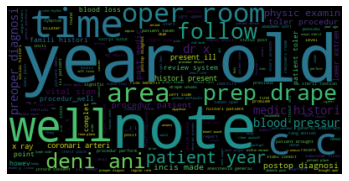

In [ ]:
# Transcription for all

def wordcloud(df):
    wordcloud_ent = WordCloud().generate(' '.join(df['stemmed_without_stop']))
    plt.imshow(wordcloud_ent, interpolation='bilinear')
    plt.axis("off")
    return plt.show()
wordcloud(df)

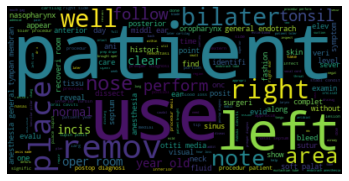

In [ ]:
# Transcription for ENT - Otolaryngology
df_ent =df.loc[(df['medical_specialty'] == ' ENT - Otolaryngology')]
wordcloud(df_ent)

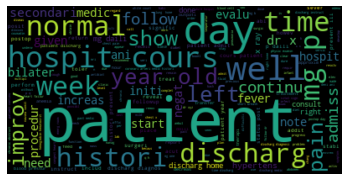

In [ ]:
# Transcription for Discharge Summary
df_dc =df.loc[(df['medical_specialty'] == ' Discharge Summary')]
wordcloud(df_dc)

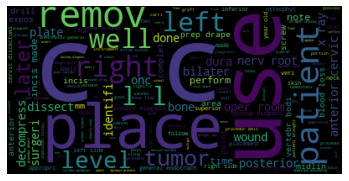

In [ ]:
# Transcription for Neurosurgery
df_neu =df.loc[(df['medical_specialty'] == ' Neurosurgery')]
wordcloud(df_neu)

In [ ]:
# because the word 'patient' is appeared very often, it is considered as stop words, so remove them
for index, row in df.iterrows():
    row['stemmed_without_stop'] = row['stemmed_without_stop'].replace('use', '')
    row['stemmed_without_stop'] = row['stemmed_without_stop'].replace('patient', '')
    row['stemmed_without_stop'] = row['stemmed_without_stop'].replace('c', '')
    row['stemmed_without_stop'] = row['stemmed_without_stop'].replace('ha', '')
    # because remove a word will leave additional place, so code below strip redundant white space
    row['stemmed_without_stop'] = row['stemmed_without_stop'].replace('  ', ' ')

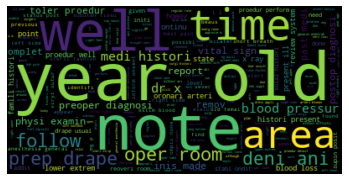

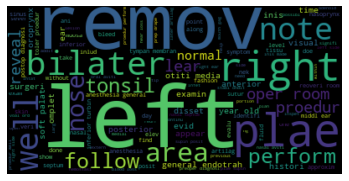

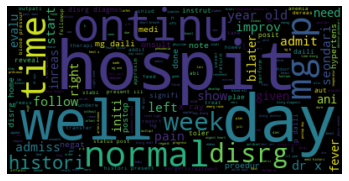

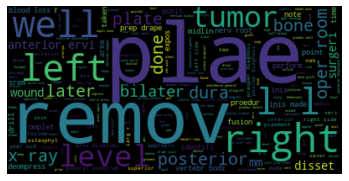

In [ ]:
# and then now the word is cleaned, does not has same words that occur many times
df_ent =df.loc[(df['medical_specialty'] == ' ENT - Otolaryngology')]
df_dc =df.loc[(df['medical_specialty'] == ' Discharge Summary')]
df_neu =df.loc[(df['medical_specialty'] == ' Neurosurgery')]
wordcloud(df)
wordcloud(df_ent)
wordcloud(df_dc)
wordcloud(df_neu)

In [ ]:
total_word_count_normalised = df['stemmed_without_stop'].str.split().str.len().sum()
print(f'The word count of transcription after normalised is: {int(total_word_count_normalised)}')
print(f'{round((total_word_count - total_word_count_normalised)/total_word_count*100, 2)}% less word')

The word count of transcription after normalised is: 1346130
41.76% less word


In [ ]:
def label_encoding(df, attribute):
    le = preprocessing.LabelEncoder()
    df['encoded_target'] = le.fit_transform(df[attribute])
    return df
df = label_encoding(df, 'medical_specialty')
df.tail(2)

,medical_specialty,stemmed_without_stop,encoded_target
4997,Allergy / Immunology,hief omplaint year old male present hildren hospit emerg depart mother asthma mother state wheez ough saw primari medi dotor evalu lini given breath treatment disrg home asthma presrib prednison antibiot told go er got wors vomit abdomin pain peak flo...,0
4998,Allergy / Immunology,histori year old male present today self refer reommend emerg room physiian nephrologist pursu allergi evalu treatment pleas refer rt histori physi well medi reord regard allerg reation treatment ab medi enter detail studi summari aut event perior swe...,0


#Text N-Gram Feature Extraction

In [ ]:
def to_list(df, attribute):
    # Select the normalised transcript column 
    df_transcription = df[[attribute]]
    # To convert the attribute into list format, but it has inner list. So it cannot put into the CountVectoriser
    unflat_list_transcription = df_transcription.values.tolist()
    # Let's use back the function defined above, "flat_list", to flatten the list
    flat_list_transcription = flat_list(unflat_list_transcription)
    return flat_list_transcription
flat_list_transcription = to_list(df, 'stemmed_without_stop')

#Extract 5 Types of N-Gram
CountVectorizer is used to convert a collection of transcript documents to a matrix of n-gram features. To explain the ngram_range, all values of n such such that min_n <= n <= max_n will be used. For example an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams.

In [ ]:
n_gram_features ={'unigram':(1,1),'unigram_bigram':(1,2),'bigram':(2,2),\
       'bigram_trigram':(2,3),'trigram':(3,3)}
feature_name=[]
temp=[]
for key, values in n_gram_features.items():
    temp.append(key)
    feature_name.append(key)
temp

['unigram', 'unigram_bigram', 'bigram', 'bigram_trigram', 'trigram']

In [ ]:
def generate_n_gram_features(flat_list_transcription):
    temp=[]
    for key, values in n_gram_features.items(): 
        vectorizer = CountVectorizer(ngram_range=values)
        vectorizer.fit(flat_list_transcription)
        temp.append(vectorizer.transform(flat_list_transcription))
    return temp
temp = generate_n_gram_features(flat_list_transcription)

#Dimension of Each Feature Vector

In [ ]:
dataframes = {'unigram':temp[0], 
              'unigram_bigram':temp[1], 
              'bigram':temp[2], 
              'bigram_trigram':temp[3], 
              'trigram':temp[4]}
feature_vector = [] ; feature_vector_shape = []
for key in dataframes:
    feature_vector.append(key)
    feature_vector_shape.append(dataframes[key].shape)

n_gram_df = pd.DataFrame({'N-Gram Feature Vector':feature_vector, 'Data Dimension':feature_vector_shape})
n_gram_df

,N-Gram Feature Vector,Data Dimension
0,unigram,"(4966, 14065)"
1,unigram_bigram,"(4966, 299615)"
2,bigram,"(4966, 285550)"
3,bigram_trigram,"(4966, 759638)"
4,trigram,"(4966, 474088)"


In [ ]:
# to retrieve a unigram feature vector
dataframes['unigram']

<4966x14065 sparse matrix of type '<class 'numpy.int64'>'
	with 814023 stored elements in Compressed Sparse Row format>

In [ ]:
# to retrieve a bigram feature vector
dataframes['bigram']

<4966x285550 sparse matrix of type '<class 'numpy.int64'>'
	with 1187924 stored elements in Compressed Sparse Row format>

In [ ]:
# to retrieve a trigram feature vector
dataframes['trigram']

<4966x474088 sparse matrix of type '<class 'numpy.int64'>'
	with 1266326 stored elements in Compressed Sparse Row format>